# Notebook used in Google Colab

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
from zipfile import ZipFile # Om de zip te unzippen
from google.colab import files # Om de zip te uploaden

file_name = "/content/drive/MyDrive/train+val.zip" # Colab slaat je bestanden op in de content folder nadat je hebt geupload dit zal dus de locatie zijn van je zip bestand nadat je het hebt geupload 


with ZipFile(file_name, 'r') as zip: 
  zip.extractall()



In [3]:
file_name1 = "/content/drive/MyDrive/test.zip" # Colab slaat je bestanden op in de content folder nadat je hebt geupload dit zal dus de locatie zijn van je zip bestand nadat je het hebt geupload 


with ZipFile(file_name1, 'r') as zip: 
  zip.extractall()


In [20]:
# disable overly verbose tensorflow logging
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # or any {'0', '1', '2'}   
import tensorflow as tf


import numpy as np
import tensorflow as tf

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras import layers
from tensorflow.keras.layers import Input, Dense, GlobalAveragePooling2D, Dropout, Flatten, Conv2D, MaxPool2D, Reshape
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard

from tensorflow.keras.applications.resnet50 import preprocess_input

# unused for now, to be used for ROC analysis
from sklearn.metrics import roc_curve, auc

allow_growth = True

# the size of the images in the PCAM dataset
IMAGE_SIZE = 96

datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

In [24]:
input_shape = (IMAGE_SIZE, IMAGE_SIZE, 3)


input = Input(input_shape)

# get the pretrained model, cut out the top layer
pretrained = tf.keras.applications.ResNet152(input_shape=input_shape, include_top=False, weights='imagenet')

output = pretrained(input)
output = GlobalAveragePooling2D()(output)
output = Dropout(0.5)(output)
output = Dense(1, activation='sigmoid')(output)

model = Model(input, output)

# note the lower lr compared to the cnn example
model.compile(SGD(lr=1e-6, momentum=0.95), loss = 'binary_crossentropy', metrics=['accuracy'])

# print a summary of the model on screen
model.summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_13 (InputLayer)        [(None, 96, 96, 3)]       0         
_________________________________________________________________
resnet152 (Functional)       (None, 3, 3, 2048)        58370944  
_________________________________________________________________
global_average_pooling2d_2 ( (None, 2048)              0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 2048)              0         
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 2049      
Total params: 58,372,993
Trainable params: 58,221,569
Non-trainable params: 151,424
_________________________________________________________________


In [25]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import glob
########### insert hyperparameters ################
train_batch_size = 32
val_batch_size = 32
###################################################

base_dir = r'/content'
test_dir = r'/content/test'

# dataset parameters
TRAIN_PATH = os.path.join(base_dir, 'train')
VALID_PATH = os.path.join(base_dir, 'valid')
TEST_FILES = glob.glob(test_dir + '\*.tif')
RESCALING_FACTOR = 1./255
IMAGE_SIZE = 96

# instantiate data generators
datagen = ImageDataGenerator(rescale=RESCALING_FACTOR)

train_gen = datagen.flow_from_directory(TRAIN_PATH,
                                    target_size=(IMAGE_SIZE, IMAGE_SIZE),
                                    batch_size=train_batch_size,
                                    class_mode='binary',
                                    shuffle=True)

val_gen = datagen.flow_from_directory(VALID_PATH,
                                    target_size=(IMAGE_SIZE, IMAGE_SIZE),
                                    batch_size=val_batch_size,
                                    class_mode='binary',
                                    shuffle=False)

# form steps
train_steps = train_gen.n//train_gen.batch_size
val_steps = val_gen.n//val_gen.batch_size

Found 144000 images belonging to 2 classes.
Found 16000 images belonging to 2 classes.


In [26]:
# save the model and weights
model_name = 'Resnet152'
model_filepath = model_name + '.json'
weights_filepath = model_name + '_weights.hdf5'

model_json = model.to_json() # serialize model to JSON
with open(model_filepath, 'w') as json_file:
    json_file.write(model_json)


# define the model checkpoint and Tensorboard callbacks
checkpoint = ModelCheckpoint(weights_filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
tensorboard = TensorBoard(os.path.join('logs', model_name))
callbacks_list = [checkpoint, tensorboard]


# train the model, note that we define "mini-epochs"
train_steps = train_gen.n//train_gen.batch_size//20
val_steps = val_gen.n//val_gen.batch_size//20

history = model.fit_generator(train_gen, steps_per_epoch=train_steps,
                    validation_data=val_gen,
                    validation_steps=val_steps,
                    epochs=25,
                    callbacks=callbacks_list)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/25
225/225 [==============================] - 75s 266ms/step - loss: 1.0430 - accuracy: 0.4870 - val_loss: 165.2066 - val_accuracy: 0.0000e+00

Epoch 00001: val_loss improved from inf to 165.20660, saving model to Resnet152_weights.hdf5
Epoch 2/25
225/225 [==============================] - 54s 241ms/step - loss: 0.9934 - accuracy: 0.5019 - val_loss: 181.8214 - val_accuracy: 0.0000e+00

Epoch 00002: val_loss did not improve from 165.20660
Epoch 3/25
225/225 [==============================] - 54s 242ms/step - loss: 0.9495 - accuracy: 0.5207 - val_loss: 62.0455 - val_accuracy: 0.0637

Epoch 00003: val_loss improved from 165.20660 to 62.04555, saving model to Resnet152_weights.hdf5
Epoch 4/25
225/225 [==============================] - 54s 241ms/step - loss: 0.9183 - accuracy: 0.5383 - val_loss: 24.2439 - val_accuracy: 0.0600

Epoch 00004: val_loss improved from 62.04555 to 24.24393, saving model to Resnet152_weights.hdf5
Epoch 5/25
225/225 [==============================] - 54s 241

In [26]:
pip install -U keras-tuner 

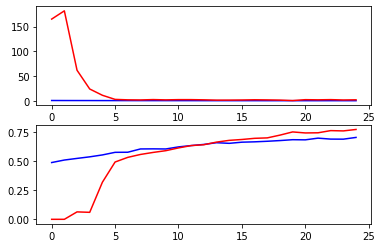

In [27]:
#Plotting the training and validation loss
import matplotlib.pyplot as plt

f,ax=plt.subplots(2,1) #Creates 2 subplots under 1 column

#Assigning the first subplot to graph training loss and validation loss
ax[0].plot(model.history.history['loss'],color='b',label='Training Loss')
ax[0].plot(model.history.history['val_loss'],color='r',label='Validation Loss')

#Plotting the training accuracy and validation accuracy
ax[1].plot(model.history.history['accuracy'],color='b',label='Training  Accuracy')
ax[1].plot(model.history.history['val_accuracy'],color='r',label='Validation Accuracy')

In [39]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # or any {'0', '1', '2'}   
import tensorflow as tf

import numpy as np

import glob
import pandas as pd
from matplotlib.pyplot import imread

from tensorflow.keras.models import model_from_json

#Change these variables to point at the locations and names of the test dataset and your models.
TEST_PATH = r"/content/test"
MODEL_FILEPATH = 'Resnet152.json' 
MODEL_WEIGHTS_FILEPATH = 'Resnet152_weights.hdf5'

# load model and model weights
json_file = open(MODEL_FILEPATH, 'r')
loaded_model_json = json_file.read()
json_file.close()
model = model_from_json(loaded_model_json)


# load weights into new model
model.load_weights(MODEL_WEIGHTS_FILEPATH)


# open the test set in batches (as it is a very big dataset) and make predictions
test_files = glob.glob(TEST_PATH + '/*.tif')

submission = pd.DataFrame()

file_batch = 5000
max_idx = len(test_files)

for idx in range(0, max_idx, file_batch):

    print('Indexes: %i - %i'%(idx, idx+file_batch))

    test_df = pd.DataFrame({'path': test_files[idx:idx+file_batch]})


    # get the image id 
    test_df['id'] = test_df.path.map(lambda x: x.split(os.sep)[-1].split('.')[0])
    test_df['image'] = test_df['path'].map(imread)
    
    
    K_test = np.stack(test_df['image'].values)
    
    # apply the same preprocessing as during draining
    K_test = K_test.astype('float')/255.0
    
    predictions = model.predict(K_test)
    
    test_df['label'] = predictions
    submission = pd.concat([submission, test_df[['id', 'label']]])


# save your submission
submission.head()
submission.to_csv('submission_resnet152.csv', index = False, header = True)


Indexes: 0 - 5000
Indexes: 5000 - 10000
Indexes: 10000 - 15000
Indexes: 15000 - 20000
Indexes: 20000 - 25000
Indexes: 25000 - 30000
Indexes: 30000 - 35000
Indexes: 35000 - 40000
Indexes: 40000 - 45000
Indexes: 45000 - 50000
Indexes: 50000 - 55000
Indexes: 55000 - 60000
